In [1]:
# classifier: cats vs. dogs
# dataset: https://www.kaggle.com/c/dogs-vs-cats

# ---------------------
# import required packages
# ---------------------
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from random import shuffle
from tqdm import tqdm
from sklearn.model_selection import train_test_split


In [2]:
# ---------------------
# define constants
# ---------------------
TRAIN_DIR = '/home/rabina7/Downloads/dogs-vs-cats/train'
TEST_DIR = '/home/rabina7/Downloads/dogs-vs-cats/test1'
IMG_SIZE = 50 # resize all images to the same size
LR = 1e-3 # learning rate: 0.001

# model name, for model loading and saving
MODEL_NAME = 'catsvsdogs-{}-{}.model'.format(LR, '6conv-basic')



In [3]:
# output of our model is an array consists 2 elements: [catniss, dogniss]
# each element represents the probability of being each animal.
# e.g., [1, 0] means this image is 100% a cat image and 0% a dog image.
# So, the final label of the image is cat.

categories = ['cat', 'dog']

def img_label(img):
    # get the true label of the image
    # images in training set are named in form of <animal>.xx.jpg, xx are numbers.
    text_label = img.split('.')[-3]
    
    if text_label == categories[0]:
        return [1, 0]
    elif text_label == categories[1]:
        return [0, 1]
    else:
        raise ValueError('The image does not belong to any category! ' + text_label)

In [4]:
# ---------------------
# process training data
# ---------------------
def process_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        # full path of the image
        img_full_path = os.path.join(TRAIN_DIR, img)
        # true label of the image
        true_label = img_label(img)
        # load the image
        img = cv2.imread(img_full_path, cv2.IMREAD_GRAYSCALE)
        # resize the image
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        # add new training data, in form of
        # (img, label)
        training_data.append([np.array(img), np.array(true_label)])
    # shuffle the dataset
    shuffle(training_data)
    # save the dataset so that next time we can load it directly
    np.save('trainset-{}.npy'.format(IMG_SIZE), training_data)
    
    return training_data       

In [5]:
# ---------------------
# process testing data
# ---------------------
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        # full path of the image
        img_full_path = os.path.join(TEST_DIR, img)
        img_idx = img.split('.')[0]
        # load the image
        img = cv2.imread(img_full_path, cv2.IMREAD_GRAYSCALE)
        # resize the image
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        # add new testing data, in form of
        # (img, img_idx)
        testing_data.append([np.array(img), img_idx])
        #calculating the testing
        #simple loop that goes through all the 
        #API to predict the label and compare to the true label
        #counter
    shuffle(testing_data)
    # save the dataset so that next time we can load it directly
    np.save('testset-{}.npy'.format(IMG_SIZE), testing_data)
    return testing_data

In [6]:
# ---------------------
# load training data
# ---------------------
def load_train_data(load_exist):
    trainset = None
    if load_exist and os.path.exists('trainset-{}.npy'.format(IMG_SIZE)):
        # if want to load an existing training set
        trainset = np.load('trainset-{}.npy'.format(IMG_SIZE), allow_pickle = True)
    else:
        trainset = process_train_data()
    return trainset

In [7]:
# ---------------------
# construct the cnn model for this project
# ---------------------
import tflearn

from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

def conv_net():
    convnet = input_data(shape = [None, IMG_SIZE, IMG_SIZE, 1],
                        name = 'input')
    # conv_2d(incoming, nb_filter, filter_size, ..., activation)
    convnet = conv_2d(convnet, 32, 5, activation = 'relu')
    # max_pool_2d(incoming, kernel_size, ...)
    convnet = max_pool_2d(convnet, 5)
    
    convnet = conv_2d(convnet, 64, 5, activation = 'relu')
    convnet = max_pool_2d(convnet, 5)
    
    convnet = conv_2d(convnet, 32, 5, activation = 'relu')
    convnet = max_pool_2d(convnet, 5)
    
    convnet = conv_2d(convnet, 64, 5, activation = 'relu')
    convnet = max_pool_2d(convnet, 5)
    
    convnet = conv_2d(convnet, 32, 5, activation = 'relu')
    convnet = max_pool_2d(convnet, 5)
    
    convnet = conv_2d(convnet, 64, 5, activation = 'relu')
    convnet = max_pool_2d(convnet, 5)
        
    # fully_connected(incoming, n_units, activation, ...)
    convnet = fully_connected(convnet, 1024, activation = 'relu')
    # dropout(incoming, keep_prob)
    convnet = dropout(convnet, 0.8)
    
    #standard recommendation for the Net arch
    
    convnet = fully_connected(convnet, 2, activation = 'softmax')
    # regression(incoming, optimizer, learning_rate, loss, name, ...)
    convnet = regression(convnet, optimizer = 'adam', learning_rate = LR,
                             loss = 'categorical_crossentropy', name = 'targets')
    
    return convnet

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
# ---------------------
# define the model
# ---------------------
convnet = conv_net()
model = tflearn.DNN(convnet, tensorboard_dir = 'log')


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.cast instead.


In [9]:
# ---------------------
# train the model
# ---------------------

# load model if exists
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print ('loaded existing model', MODEL_NAME)
else:
    # Loading the training data-set after pre-processing
    # and splitting the testing data and validation data

    train_data = load_train_data(True)
    train = train_data[:-500]
    validation = train_data[-500:]

    # Setting up the features and lables
    # x-Features & y-Labels
    train_x = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
    train_y = [i[1] for i in train]
    validation_x = np.array([i[0] for i in validation]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
    validation_y = [i[1] for i in validation]
    # Training the CNN model with the data-sets
    model.fit({'input': train_x}, {'targets': train_y}, n_epoch = 15,
                        validation_set = ({'input': validation_x}, {'targets': validation_y}),
                        snapshot_step = 500, show_metric = True, run_id = MODEL_NAME)

    # save the trained model
    #model.save(MODEL_NAME)

Training Step: 5744  | total loss: 0.15682 | time: 24.223s
| Adam | epoch: 015 | loss: 0.15682 - acc: 0.9400 -- iter: 24448/24500
Training Step: 5745  | total loss: 0.16291 | time: 24.368s
| Adam | epoch: 015 | loss: 0.16291 - acc: 0.9350 | val_loss: 0.83730 - val_acc: 0.7520 -- iter: 24500/24500
--


In [10]:
# the model acheives 90% accuracy, save it if not saved yet
if not os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.save(MODEL_NAME)

INFO:tensorflow:/home/rabina7/Downloads/catsvsdogs-0.001-6conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


In [11]:
# ---------------------
# load testing data
# ---------------------
def load_test_data(load_exist):
    testset = None
    if load_exist and os.path.exists('testset-{}.npy'.format(IMG_SIZE)):
        # if want to load an existing testing set
        testset = np.load('testset-{}.npy'.format(IMG_SIZE), allow_pickle = True)
    else:
        testset = process_test_data()
    return testset

In [12]:

train_data = load_train_data(True)
train = train_data[:-500]
validation = train_data[-500:]
train_x = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
train_y = [i[1] for i in train]
validation_x = np.array([i[0] for i in validation]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
validation_y = [i[1] for i in validation]

predictions = model.predict(validation_x)
total_test_samples = len(validation_y)
counter = 0
for prediction, actual in zip(predictions, validation_y):
    predicted_class = np.argmax(prediction)
    actual_class = np.argmax(actual)
    if(predicted_class == actual_class):
        counter+=1
    print(predicted_class, actual_class)

    accuracy = counter / total_test_samples
    print("The testing accuracy is {}.".format(accuracy))

(0, 1)
The testing accuracy is 0.
(0, 0)
The testing accuracy is 0.
(0, 1)
The testing accuracy is 0.
(1, 1)
The testing accuracy is 0.
(0, 1)
The testing accuracy is 0.
(0, 0)
The testing accuracy is 0.
(0, 0)
The testing accuracy is 0.
(0, 1)
The testing accuracy is 0.
(1, 1)
The testing accuracy is 0.
(0, 0)
The testing accuracy is 0.
(0, 1)
The testing accuracy is 0.
(1, 1)
The testing accuracy is 0.
(0, 0)
The testing accuracy is 0.
(1, 1)
The testing accuracy is 0.
(1, 1)
The testing accuracy is 0.
(0, 0)
The testing accuracy is 0.
(1, 1)
The testing accuracy is 0.
(1, 1)
The testing accuracy is 0.
(1, 1)
The testing accuracy is 0.
(0, 1)
The testing accuracy is 0.
(1, 0)
The testing accuracy is 0.
(1, 1)
The testing accuracy is 0.
(1, 0)
The testing accuracy is 0.
(0, 1)
The testing accuracy is 0.
(0, 1)
The testing accuracy is 0.
(0, 0)
The testing accuracy is 0.
(0, 1)
The testing accuracy is 0.
(1, 1)
The testing accuracy is 0.
(1, 1)
The testing accuracy is 0.
(1, 0)
The tes

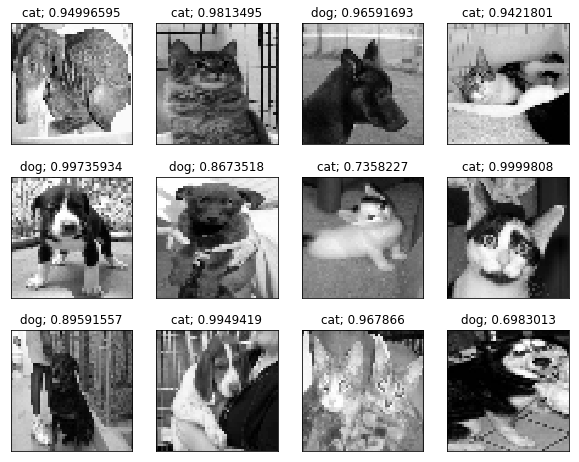

In [14]:
# -------------------
# use trained model to predict given image
# -------------------
import matplotlib.pyplot as plt

test_data = load_test_data(True)
fig = plt.figure(figsize = (10, 8))

# test and plot 12 images
for i, data in enumerate(test_data[:12]):
    # cat: [1, 0]; dog: [0, 1]
    img_data = data[0]
    img_idx = data[1]
    
    sub_fig = fig.add_subplot(3, 4, i + 1)
    
    orig_data = img_data
    # flatten image
    data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
    
    output = model.predict([data])[0]
    
    if np.argmax(output) == 1:
        pred_label = 'dog'
    else:
        pred_label = 'cat'
    
    sub_fig.imshow(orig_data, cmap = 'gray')
    
    # predicted label and confidence
    plt.title(pred_label + '; ' + str(np.max(output)))
    sub_fig.get_xaxis().set_visible(False)
    sub_fig.get_yaxis().set_visible(False)
    
plt.show()